# 3D Brain Tumor Segmentation with nnU-Net and Patch-Learning


## Table of contents
* Introduction
* Dataset
* Data-Preprocessing
* Data Loading
* Loss function
* Models
* Training
* Inference


## Introduction

The goal of this project is to train an accurate 3D Neural Network for Glioblastoma Tumor Segmentation using a limited dataset. To this end, we make use of Patch-Learning. Our work combines the BraTS21 winning U-Net design : [Optimized U-Net for Brain Tumor Segmentation](https://arxiv.org/abs/2110.03352) and the BraTS20 winning learning approach : [nnU-Net for Brain Tumor Segmentation](https://arxiv.org/abs/2011.00848). In this Notebook, we will guide you through how to reproduce our results and detail the thinking behind it. In particular, we will introducde the version of the BraTS dataset used, the applied preprocessing and Patch-Learning strategy, the loss function, the U-Net architecture and finally, we will train a model for a few epochs and perform inference on a few samples.  

In [1]:
# Cloning git repo and installing missing dependencies
!git clone https://github.com/Jawher-Ben-Abdallah/Glioblastoma_3D_Segmentation.git
!pip install monai
!mkdir predictions

Cloning into 'Glioblastoma_3D_Segmentation'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 61 (delta 23), reused 55 (delta 17), pack-reused 0
Unpacking objects: 100% (61/61), 17.67 KiB | 1005.00 KiB/s, done.
     |████████████████████████████████| 721 kB 4.3 MB/s            


## Dataset
The training dataset is provided by the [BraTS20](https://www.med.upenn.edu/cbica/brats2020/data.html) challenge. It consists of 369 brain mpMRI scans with the corresponding segmentation masks of the tumorous region. The 3D volumes were skull-stripped and resampled to 1 mm isotropic resolution, with a dimension of (240, 240, 155) voxels, (Height, Width, Depth). For each example, four modalities have been given: Fluid Attenuated Inversion Recovery (FLAIR), native (T1), post-contrast T1-weighted (T1Gd), and T2-weighted (T2). The segmentation labels are as follows: 0 Background, 1 Necrotic Tumor Core (NCR), 2 Edema (ED) and 4 Enhancing Tumor (ET).

We visualize the BraTS20_Training_001 sample, plotting the different modalities and the accompanying annotation. From left to right: FLAIR, T1, T1Gd, T2 and segmentation labels. 

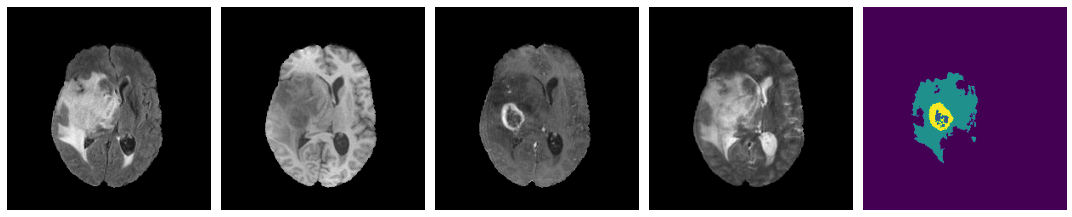

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk


path = "../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"
imgs = [sitk.GetArrayFromImage(sitk.ReadImage(path + f"/BraTS20_Training_001_{m}.nii")).astype(np.float32)[75]
       for m in ["flair", "t1", "t1ce", "t2"]]
labels = sitk.GetArrayFromImage(sitk.ReadImage(path + "/BraTS20_Training_001_seg.nii")).astype(np.uint8)[75]
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(labels, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()
plt.show()

### Data Preprocessing

We stick to a few preprocessing techniques that were shown to be effective throughout the many BraTS challenges. Since each patient has 4 available sequences in [NIfTI](https://nifti.nimh.nih.gov/) format, we read each sequence using the SimpleITK library and concatenate them in a single array along with their corresponding segmentation mask to obtain a (5, 155, 240, 240) array. Afterwards, we crop the non-zero region of the brain, removing the redundant background. We then normalize each sequence seperatly by subtracting its mean and dividing by its standard deviation. Finally, we save our input tensors to a numpy format.

In [3]:
#!python ./Glioblastoma_3D_Segmentation/preprocess.py --input_dir ../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData --output_dir Preprocessed

## Data Loading and Patch Learning

We train our network with randomly sampled 128x128x128 patches voxels with a batch size of 2. We refer to one epoch as an interation over 200 batches. Using this aggressive technique artificially bloats the number of training samples without leading to overfitting.

## Loss Function

The BraTS leaderboard is computed based on three partially overlapping regions: whole tumor (1, 2, 4), tumor core (1, 4) and enhancing tumor (4), instead of classes present in the labels. Thus, it is beneficial to construct the loss function based on classes used for ranking calculation. Therefore, we optimize each region separately with a sum of binary Cross-Entropy with the Dice loss.

In [4]:
import torch.nn as nn
from monai.losses import DiceLoss

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

## nnU-Net

For this project, we used the Optimized No New U-Net which won the 2021 BraTS Challenge.

The U-Net has been a staple in Medical Imaging Segmentation. With its Encoder-Decoder architecture, it's able to perform feature-extraction via the repeating convolutional blocks then with its rich Decoder coupled with the skip-connection, we can propagate contextual information and capture high-resolution features from the Encoder.

To reduce memory usage, we choose an encoder of depth 4, taking advantage of the MONAI model-zoo.

Note : We train the U-Net from scartch. No pre-trained weights are applied.

![](https://raw.githubusercontent.com/NVIDIA/DeepLearningExamples/a43ffd01cb002b23a98c97c3c5a231e24a57fa71/PyTorch/Segmentation/nnUNet/images/unet3d.png)

## Training

Let's get to training!
You can call the training script from this repository to do so, setting the command line argument `--exec_mode` to 'train'.

You can also set these command line argument for testing purposes:
* `--samples_per_epoch 400` - Number of randomly sampled patches used per epoch.
* `--num_epoch 10` - Number of training epochs.
* `--learning_rate 0.0001` - Training Learning Rate.
* `--weight_decay 0.00001` - Weight Decay.

We train the nnU-Net for $10$ epochs with a learning rate and weight decay of $1e^{-4}$ and $1e^{-5}$ respectively.
Since we do not own a high performing GPU, we use [Kaggle's](http://kaggle.com) free Nvidia Tesla P100 GPU.

The best performing model based on the mean DICE score for all three regions is saved for inference.

In [5]:
!python ./Glioblastoma_3D_Segmentation/main.py --base_dir ../input/brats2020/BraTS2020_Preprocessed --samples_per_epoch 400 --num_epochs 10

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Epoch 0:  91%|██████████▉ | 200/220 [05:16<00:31,  1.58s/it, loss=2.88, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|██████████▉ | 200/220 [04:56<00:29,  1.48s/it, loss=2.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|██████████▉ | 200/220 [04:49<00:28,  1.45s/it, loss=2.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  91%|██████████▉ | 200/220 [04:52<00:29,  1.46s/it, loss=2.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|██████████▉ | 200/220 [04:51<00:29,  1.46s/it, loss=2.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  91%|██████████▉ | 200/220 [04:54<00:29,  1.47s/it, loss=2.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  91%|██████████▉ | 200/220 [04:54<00:29,  1.47s/it, loss=2.17, v_num=0]
Val

## Inference 

To run the script on inference mode, run the previous script, setting the command line argument `--exec_mode` to 'predict'

The predict set used is a small subset taken from the preprocessed data. Since the input shape is arbitrary, we pad the volumes to 224x224x224. You can also run inference using any saved model by specifying the command line argument `--ckpt_path`.

Model predictions as well as their corresponding labels are saved to the specific folder passed in the command line argument `--pred_dir`.

In [6]:
!python ./Glioblastoma_3D_Segmentation/main.py --base_dir ../input/brats2020/BraTS2020_Preprocessed --exec_mode 'predict' --ckpt_path ./best_model.ckpt --pred_dir ./predictions

Predicting: 0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:141: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")
Predicting: 100%|█████████████████████████████████| 5/5 [00:15<00:00,  3.18s/it]


## Visualization

Finally, we visualize some predictions!

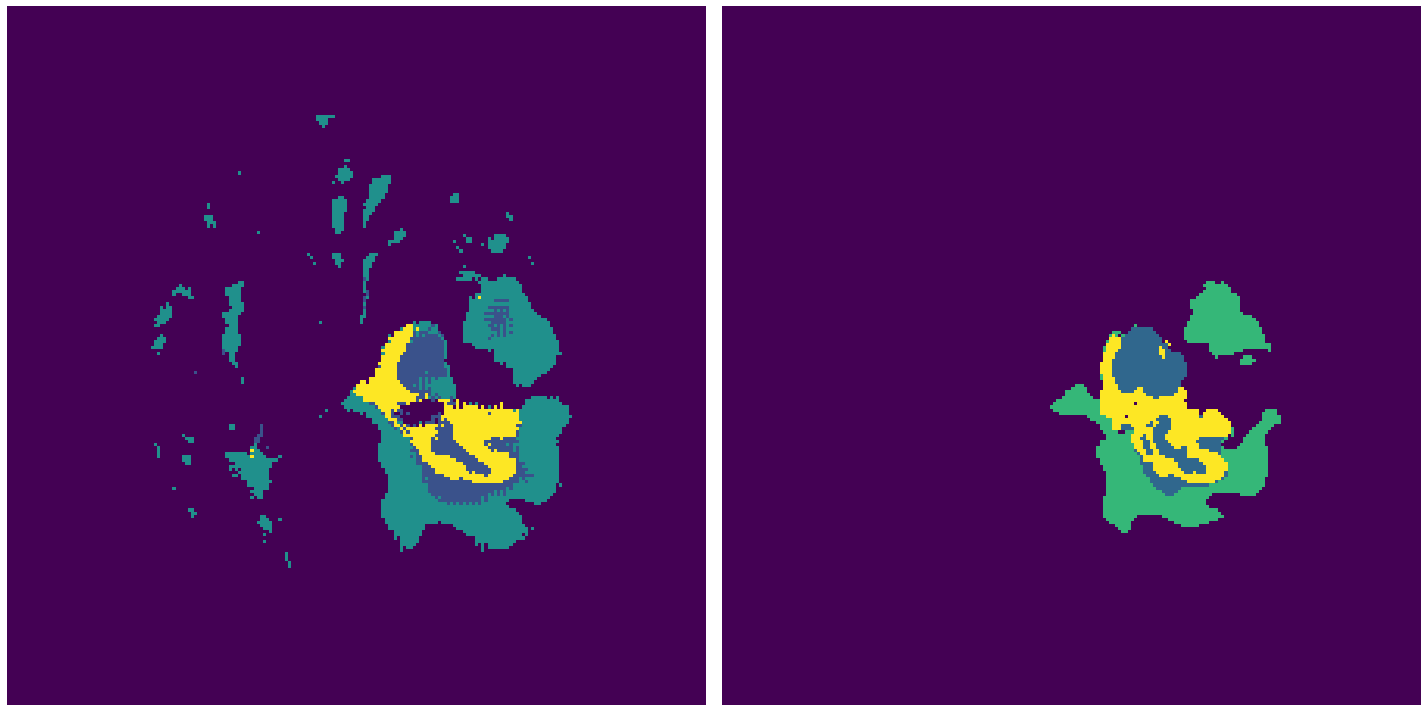

In [7]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

pred_sample = np.load("./predictions/BraTS20_Training_208-prediction.npy")[0]
lbl_sample = np.load("./predictions/BraTS20_Training_208-label.npy")[0, 0]

def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c3 == False) * (c2 == True)] = 1
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4 
    return pred

pred_sample = to_lbl(pred_sample)

fig, ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].imshow(pred_sample[120])
ax[0].axis('off')
ax[1].imshow(lbl_sample[120])
ax[1].axis('off')
plt.tight_layout()            
plt.show()